In [316]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack
import random

Variable initialization

In [317]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

Text(0.5, 1.0, 'DCT basis')

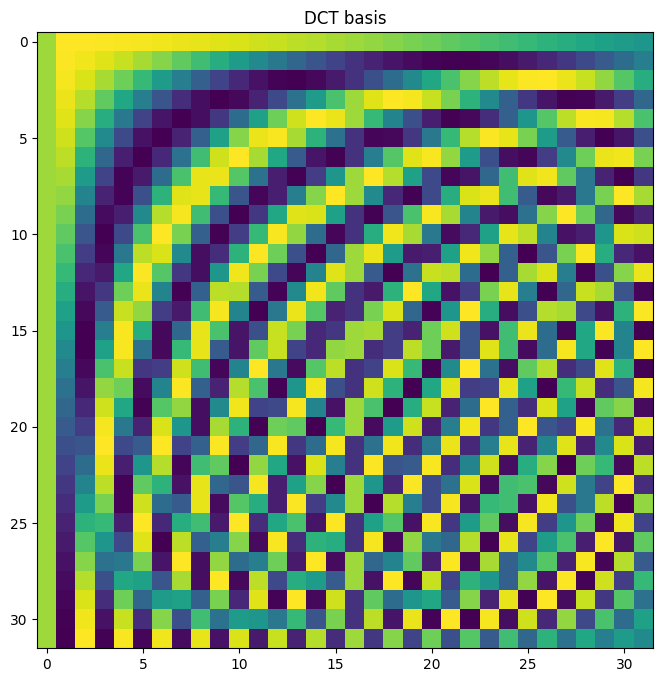

In [318]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    DCT[:, i] = sp.fftpack.idct(a, norm='ortho')

plt.figure(figsize=(8,8))
plt.imshow(DCT)
plt.title('DCT basis')


Generating the 1-D standard basis

Text(0.5, 1.0, 'Canonical basis dimension n = 32')

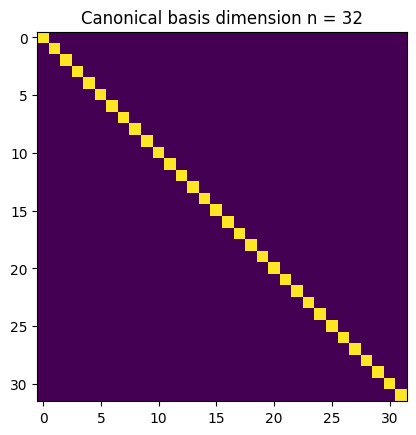

In [319]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    C[:, i] = a

plt.figure(5)
plt.imshow(C)
plt.title(f'Canonical basis dimension n = {M}')


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

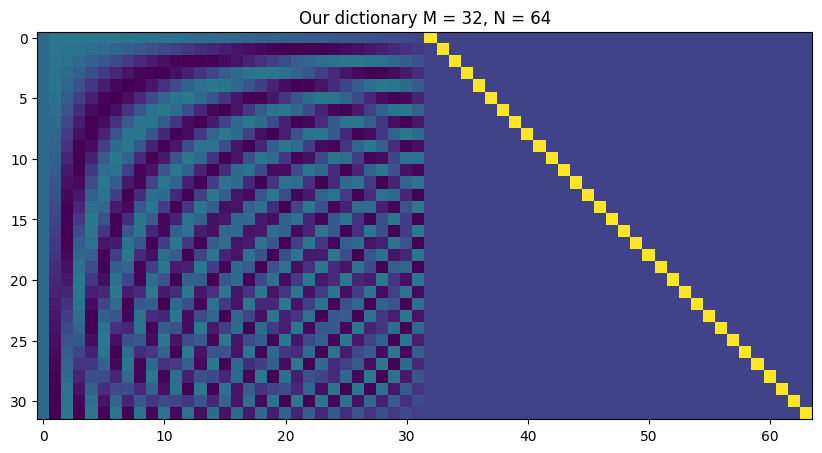

In [320]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [321]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [322]:
ind = np.random.randint(0,M,L)
x0 = np.zeros(N)
x0[ind] = np.random.rand(L) + 2



Choose spike location and update x0

In [323]:
spikeLocation = random.randint(M,N) 
# the spike needs to be placed in the last coefficients of D, wrt to the canonical basis
x0[spikeLocation] = -10

Synthetize the corresponding signal in the signal domain and add noise


In [324]:
s0 = D@x0
s = s0 + np.random.normal(size=M) * sigma_noise

Plot the sparse signal

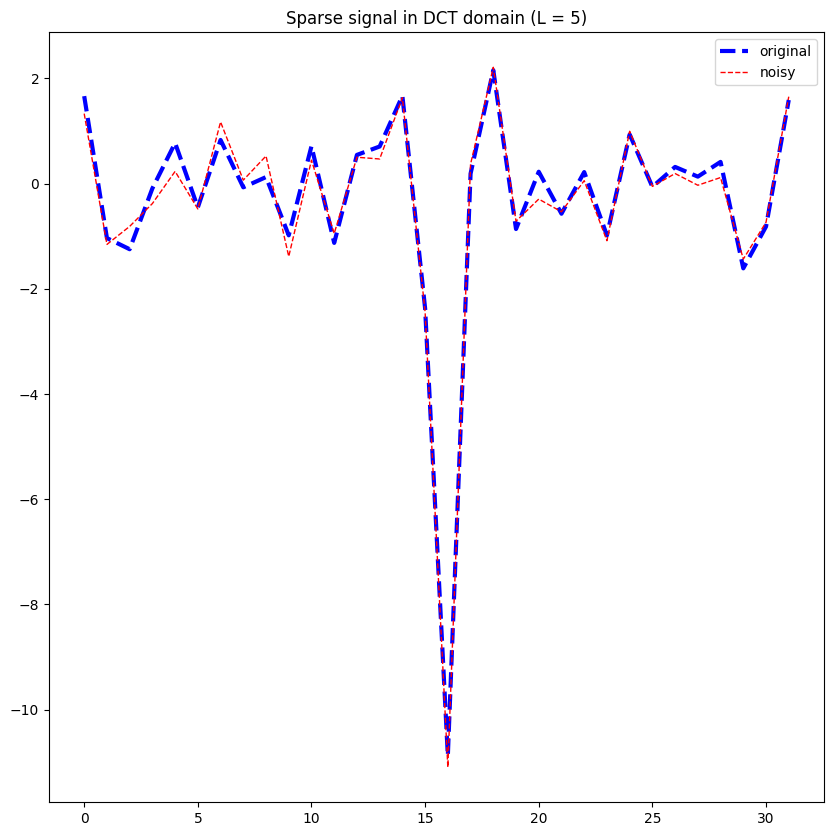

In [325]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(10,10))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Tichonov's Regularization
-----------------------
Compute the representation w.r.t. $D$ using Tichonov's regularization

In [326]:
lmbda = 1

#x_tic = np.linalg.inv(D.T@D + lmbda*np.eye(N)) @ D.T @ s
# witout computing the inverse:
x_tic = np.linalg.solve(D.T@D + lmbda*np.eye(N), D.T @ s)

s_hat_tic = D@x_tic

Show the results

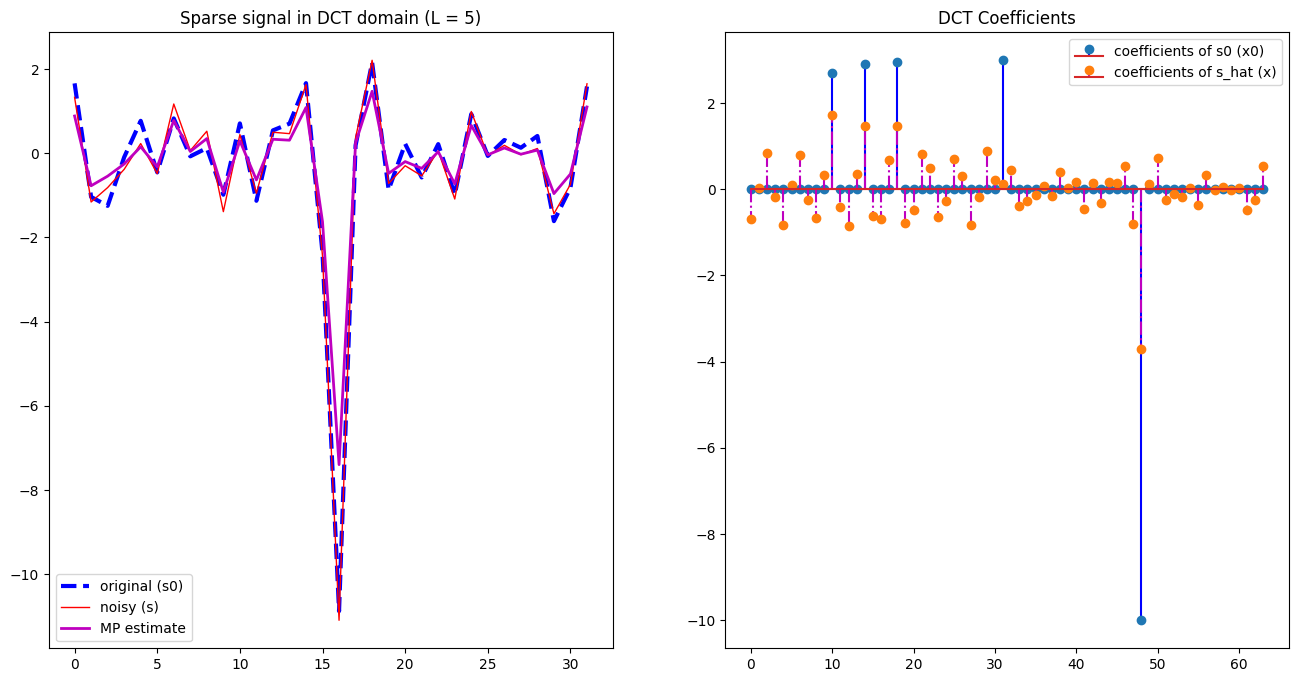

In [327]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_tic, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_tic, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x)'])

Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [328]:
x_MP = np.zeros(N)
r = s
l = 1

#initialize the norm of the residual (components not represented by the coefficients)
resNorm = np.linalg.norm(r,2)
MINIMUM_RES_NORM = 0.1

MP loop starts.

Stopping criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [329]:
while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:
  # SWEEP STEP: look for the column of D that matches at best noisySignal
  # compute the residual w.r.t. each column of D
  e = np.zeros(N)
  z= np.zeros(N)
  for j in range(N):
    z[j] = r.T @ D[:,j]
    e[j] = (resNorm**2) - z[j]**2 
    
  # find the column of D that matches at best r
  jStar = np.argmin(e) 

  # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
  x_MP[jStar] += z[jStar] 

  # remove the signal we have so far represented in coeff_MP (update the residual)
  r = s - D@x_MP
  # component that cannot be captured by the signal (the signal at the very beginning)

  l = l + 1

  # update the residual norm
  resNorm = np.linalg.norm(r,2)

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [330]:
s_hat_MP = D@x_MP

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [331]:
resNorm_MP = np.linalg.norm(r,2)


Show the result

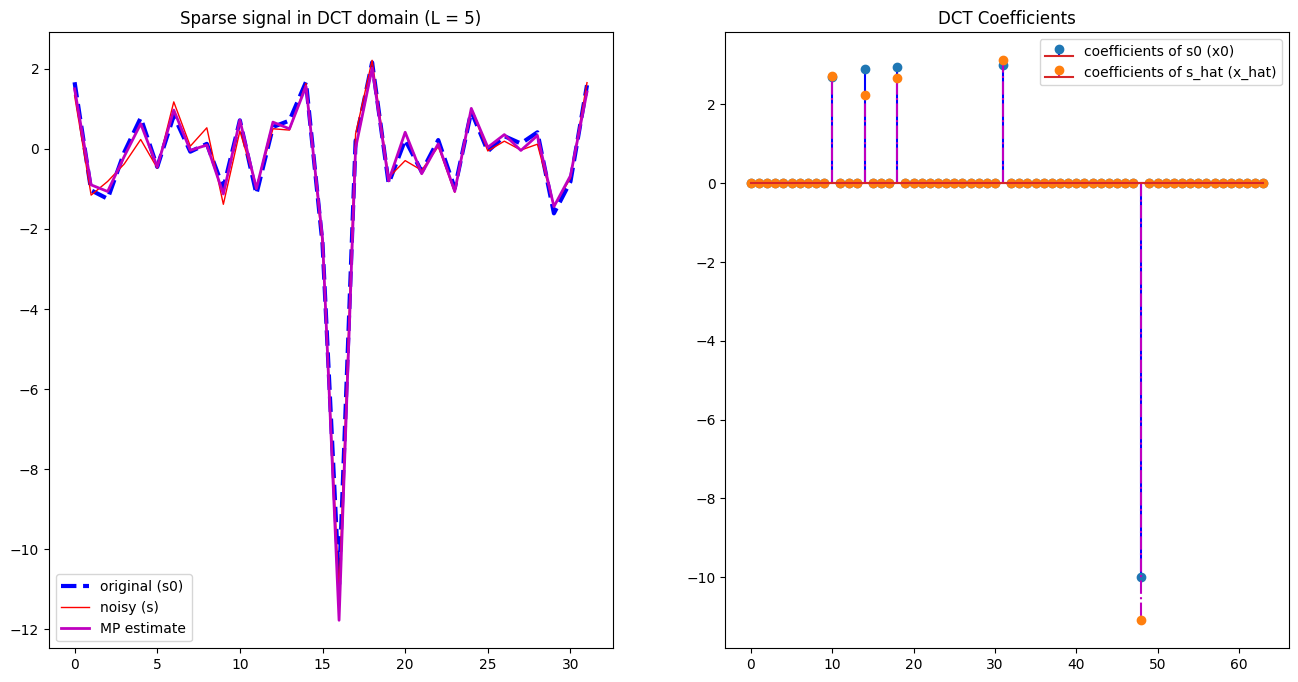

In [332]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])